In [20]:
import numpy as np
import scipy
import xarray as xr
import sys
from calendar import monthrange
import os
import matplotlib.pyplot as plt
import cmocean
from scipy import stats,signal


In [33]:
# Input from reading list of dates

dir_root = "/scratch/mgomez/STORM/idealSims/sst_32_skipd01_skipCoLES_ndg/"
dir_root = "/scratch/mgomez/STORM/idealSims/sst_31_skipd01_skipCoLES_ndg/"
# dir_root = "/projects/storm/mgomez/idealSims/sst_30_skipd01_skipCoLES_ndg/Results/"
# dir_root = "/scratch/mgomez/STORM/idealSims/sst_31md_skipd01_skipCoLES_ndg/"
dir_root = "/projects/storm/mgomez/idealSims/sst_32_skipd01_skipCoLES_ndg/Results/"

# Maximum height (to save memory)
iz_MMiin = 0 # 0 # 4
iz_MMaax = 15 #20 # 30 # 7
iz_max = iz_MMaax
iz_inBetween = 2 #2 # 2 # 1

# Make or not GIF
makeGIF = False

# Choose domain
domain = 'd01'
# File name root
fName = 'auxHist'
# File name contains this
fOther = ':00' # '06_04' # ':00' # '06_1' # ':00:'


# Find auxHist files for current domain within directory
entries = os.listdir(dir_root)
ofInterest = []
for ii in np.arange(len(entries)):
    # Check if file name matches
    if domain in entries[ii]:
        if fName in entries[ii]:
            if fOther in entries[ii]:
                ofInterest = np.append(ofInterest,ii)
ofInterest = ofInterest.astype('int')
rndmFromInterest = np.random.choice(ofInterest)

entries = ["auxHist24_d02_2000-01-05_07:00:00","auxHist24_d02_2000-01-05_07:10:00"]
ofInterest = [0,1]
# entries = ["auxHist24_d02_2000-01-05_07:05:00","auxHist24_d02_2000-01-05_07:15:00",
#            "auxHist24_d02_2000-01-05_07:25:00","auxHist24_d02_2000-01-05_08:04:00"]
# ofInterest = np.arange(len(entries)) #[0,1,2,3,4]

# Extract and save data from each auxHist file (simulations WITHOUT turbines)
for i_f in np.arange(0,len(ofInterest)):
    # Open file
    ds = xr.open_dataset(dir_root+str(entries[ofInterest[i_f]]),decode_times=False)
    # Extract data
    u_temp = np.array(ds['U'])
    v_temp = np.array(ds['V'])
    w_temp = np.array(ds['W'])
    t_temp = np.array(ds['T']) + 300
    time_temp = np.array(ds['Times'])
    # De-stagger variables
    u_temp = 0.5*(u_temp[:,:,:,0:np.shape(u_temp)[3]-1]+u_temp[:,:,:,1:np.shape(u_temp)[3]])
    v_temp = 0.5*(v_temp[:,:,0:np.shape(v_temp)[2]-1,:]+v_temp[:,:,1:np.shape(v_temp)[2],:])
    w_temp = 0.5*(w_temp[:,0:np.shape(w_temp)[1]-1,:,:]+w_temp[:,1:np.shape(w_temp)[1],:,:])
    # Save variables
    if i_f == 0:
        # Only keep data within heights of interest
        u_temp = u_temp[:,iz_MMiin:iz_max:iz_inBetween,:,:]
        v_temp = v_temp[:,iz_MMiin:iz_max:iz_inBetween,:,:]
        w_temp = w_temp[:,iz_MMiin:iz_max:iz_inBetween,:,:]
        t_temp = t_temp[:,iz_MMiin:iz_max:iz_inBetween,:,:]
        # Create new variables
        u = np.zeros_like(u_temp) + u_temp
        v = np.zeros_like(v_temp) + v_temp
        w = np.zeros_like(w_temp) + w_temp
        theta = np.zeros_like(t_temp) + t_temp
        Time = []
        Time.append(time_temp)
        # Domain dimensions
        dx = ds.DX
        n_x = dx*np.arange(0,np.shape(u)[3])
        n_y = dx*np.arange(0,np.shape(u)[2])
    else: #if i_f>0:
        # Only keep data within heights of interest
        u_temp = u_temp[:,iz_MMiin:iz_max:iz_inBetween,:,:]
        v_temp = v_temp[:,iz_MMiin:iz_max:iz_inBetween,:,:]
        w_temp = w_temp[:,iz_MMiin:iz_max:iz_inBetween,:,:]
        t_temp = t_temp[:,iz_MMiin:iz_max:iz_inBetween,:,:]
        # Append data to saved variables
        u = np.append(u,u_temp,axis=0)
        v = np.append(v,v_temp,axis=0)
        w = np.append(w,w_temp,axis=0)
        theta = np.append(theta,t_temp,axis=0)
        Time.append(time_temp)
    # Free-up memory
    u_temp = 0.0
    v_temp = 0.0
    w_temp = 0.0
    t_temp = 0.0
    # Close file
    ds.close()
    print("Done with %i out of %i" % (i_f+1,len(ofInterest)))
print("Done extracting data")


# Height variable
if os.path.exists(dir_root +"/wrfinput_"+domain): 
    ds = xr.open_dataset(dir_root +"/wrfinput_"+domain,decode_times=False) 
elif os.path.exists(dir_root +"../wrfinput_"+domain): 
    ds = xr.open_dataset(dir_root +"../wrfinput_"+domain,decode_times=False) 
else:
    entries = os.listdir(dir_root)
    for ii in np.arange(len(entries)):
        # Check if file name matches
        if domain in entries[ii]:
            if 'wrfout' in entries[ii]:
                ofInterest = ii
    ds = xr.open_dataset(dir_root +entries[ofInterest],decode_times=False)
ph = ds['PH']
ph = np.array(ph[0,:,:,:])
phb = ds['PHB']
phb = np.array(phb[0,:,:,:])
height_stag = (ph+phb)/9.81
height_agl = 0.5*(height_stag[1:,:,:] + height_stag[0:-1,:,:])
# height_agl = height_agl[0:iz_max,:,:]
# Free-up memory
ph = 0.0
phb = 0.0
# height_stag = 0.0
ds.close()
ds = 0.0    

height_agl = np.mean(height_agl,axis=(1,2))
height_agl = height_agl[iz_MMiin:iz_max:iz_inBetween]

height_stag = np.mean(height_stag,axis=(1,2))
height_stag = height_stag[iz_MMiin:iz_max+iz_inBetween:iz_inBetween]


Done with 1 out of 2
Done with 2 out of 2
Done extracting data


In [22]:
#%% Extract variables from file
# ds=xr.open_dataset(WRF_DIRECTORY+WRF_FILES,decode_times=False)
# # Wind speed
# u = ds['U']
# u = np.array(u[:,0,:,:,:])
# v = ds['V']
# v = np.array(v[:,0,:,:,:])
# w = ds['W']
# w = np.array(w[:,0,:,:,:])
# # De-stagger wind speed
# u = 0.5*(u[:,:,:,0:np.shape(u)[3]-1]+u[:,:,:,1:np.shape(u)[3]])
# u = 0.0
# v = 0.5*(v[:,:,0:np.shape(v)[2]-1,:]+v[:,:,1:np.shape(v)[2],:])
# v = 0.0
# w = 0.5*(w[:,0:np.shape(w)[1]-1,:,:]+w[:,1:np.shape(w)[1],:,:])
# w = 0.0
# # Calculate horizontal wind speed
# uv = np.sqrt(np.array(u)**2 + np.array(v)**2)
# # Potential temperature
# t = ds['T']
# theta = np.array(t[:,0,:,:,:]) + 300
# # t_skin = ds['TSK']
# # t_skin = np.array(t_skin[:,0,:,:]) 
# #t_skin = np.mean(np.mean(t_skin,axis=1),axis=1)
# # Time
# Time = ds['Times']
# Time = np.array(Time)
# # Domain dimensions
# dx = ds.DX
# n_x = dx*np.arange(0,np.shape(uv)[3])
# n_y = dx*np.arange(0,np.shape(uv)[2])
# # Time step
# DT = ds.DT
# ds.close()

# # Extract height variables
# height_agl = np.array([  10.597356,   32.311485,   55.092354,   78.99515 ,  104.0753  ,
#         130.39023 ,  158.00024 ,  186.9681  ,  217.35979 ,  249.24423 ,
#         282.6931  ,  317.78162 ,  354.5885  ,  393.19598 ,  433.68988 ,
#         476.15973 ,  520.69885 ,  567.405   ,  616.37897 ,  667.7255  ,
#         721.5572  ,  777.9966  ,  836.4701  ,  895.6054  ,  954.67004 ,
#        1013.6671  , 1072.5979  , 1131.4629  , 1190.2615  , 1248.9944  ,
#        1307.6619  , 1366.2639  , 1424.8013  , 1483.2748  , 1541.6855  ,
#        1600.0352  , 1658.3245  , 1716.5544  , 1774.7263  , 1832.8411  ,
#        1890.8989  , 1948.9011  , 2020.3508  , 2109.452   , 2207.3105  ,
#        2314.771   , 2432.7532  , 2562.2632  , 2704.398   , 2860.3533  ,
#        3031.435   , 3219.0693  , 3424.821   , 3650.4092  , 3897.7112  ,
#        4168.765   , 4465.787   , 4791.201   , 5145.6133  , 5513.3467  ])
# dz = height_agl[1:] - height_agl[0:-1]
# height_stag = np.zeros_like(height_agl)
# for i in np.arange(1,len(height_stag)):
#     height_stag[i] = height_stag[i-1] + dz[i-1]
# height_agl = height_agl[0:np.shape(uv)[1]]
# height_stag = height_stag[0:np.shape(uv)[1]+1]


# Turbine specifications
D = 126
z_hh = 90
rated_ws = 11.4

print("done extracting variables")

done extracting variables


In [34]:
#%% Create time vector (after initialization) (ignore dates)
# Create large datetime64 array
ttime = np.arange('2000-01-01T00:00:00', '2000-01-02T00:00:00',np.shape(Time)[0], dtype='datetime64')
# Save actual times for simulation
for i_t in np.arange(0,np.shape(Time)[0]):
    a = str(Time[i_t])
    ttime[i_t] = np.datetime64(a[3:13] + str(' ')+ a[14:-2])
    # ttime[i_t] = ttime[0] + np.timedelta64(5*60,dtype='datetime64[s]')*i_t
# Save portion of temp array that actually matters
ttime = ttime[0:np.shape(Time)[0]]

print(ttime)

['2000-01-05T07:00:00' '2000-01-05T07:10:00']


In [35]:
#%% Sort arrays by time
i_sort = np.argsort(ttime)
u = u[i_sort,:,:,:]
v = v[i_sort,:,:,:]
w = w[i_sort,:,:,:]
theta = theta[i_sort,:,:,:]
ttime = ttime[i_sort]

uv = (u**2 + v**2)**0.5


In [36]:
#%% Time since initialization
# t_init = np.datetime64('2000-01-05T00:00:23')
t_init = np.datetime64('2000-01-01T00:00:13')

time_sinceInit = ttime - t_init
time_sinceInit = time_sinceInit.astype('timedelta64[s]')

t_since = time_sinceInit.astype('float')/3600 # [hr]


In [37]:
#%% Find hub-height
i_hh = np.argmin(np.abs(height_agl - z_hh))


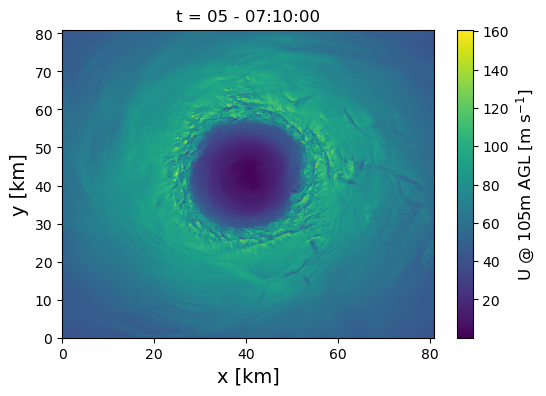

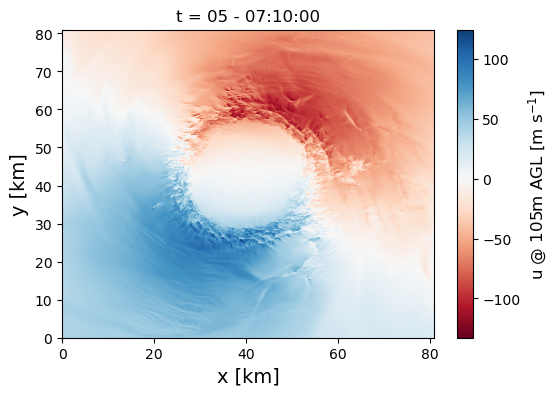

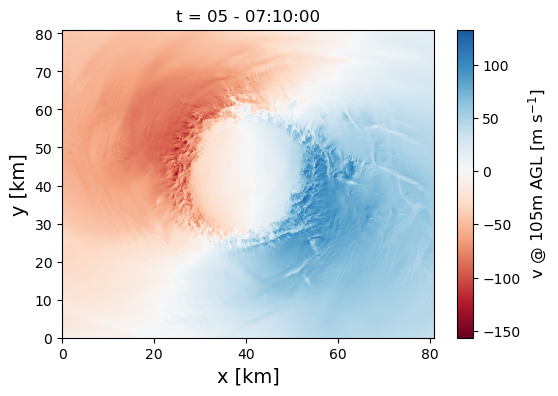

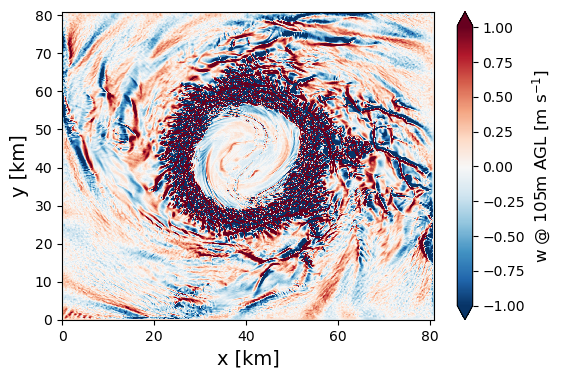

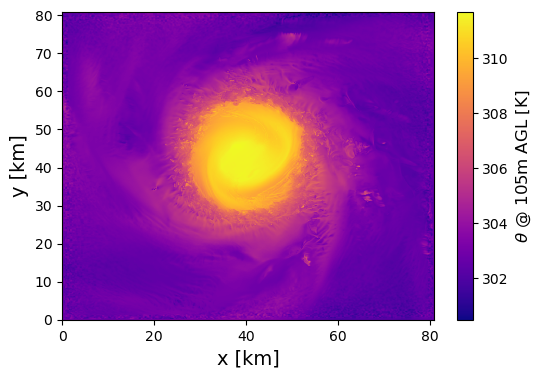

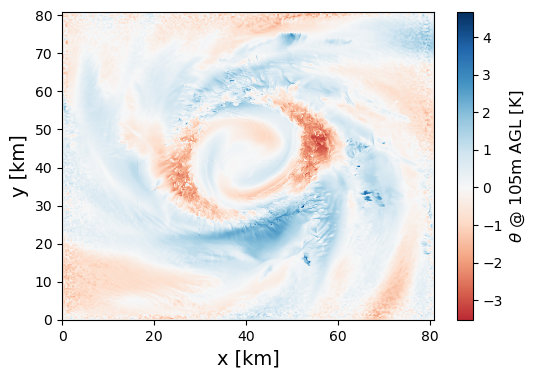

In [44]:
#%% Plot wind speed at one height
iz = 2 #np.min([9,len(height_agl)-1])#np.argmin(np.abs(height_agl - z_hh))
it = -1 #-7

# Horizontal wind speed
plt.figure(figsize=(6,4))
plt.title('t = '+str(ttime[it])[8:10]+' - '+str(ttime[it])[11:])
im1 = plt.pcolormesh(n_x/1000,n_y/1000,uv[it,iz,:,:])
cbar = plt.colorbar(im1)
cbar.set_label('U @ ' + str(int(height_agl[iz])) + 'm AGL [m s$^{-1}$]',fontsize=12)
plt.ylabel('y [km]',fontsize=14)
plt.xlabel('x [km]',fontsize=14)
#plt.scatter(n_x[4]/1000,n_y[4]/1000,color='r')
#if 'merged_d05.nc' in domain:
#    plt.scatter(n_x[locs_ts[:,0]]/1000,n_y[locs_ts[:,1]]/1000,s=5,color='red')
#plt.xlim(143*dx/1000,(143*dx + 403*4500)/1000)
#plt.ylim(143*dx/1000,(143*dx + 403*4500)/1000)
#plt.ylim(2000,4000)
#plt.xlim(2000,4000)
plt.show()
plt.close()


# Zonal wind speed
plt.figure(figsize=(6,4))
u[it,iz,0,0] = 0.5
u[it,iz,0,1] = -0.5
newCmap = cmocean.tools.crop(plt.cm.RdBu, np.min(u[it,iz,:,:]), np.max(u[it,iz,:,:]), 0)
plt.title('t = '+str(ttime[it])[8:10]+' - '+str(ttime[it])[11:])
im1 = plt.pcolormesh(n_x/1000,n_y/1000,u[it,iz,:,:],cmap=newCmap)
cbar = plt.colorbar(im1)
cbar.set_label('u @ ' + str(int(height_agl[iz])) + 'm AGL [m s$^{-1}$]',fontsize=12)
plt.ylabel('y [km]',fontsize=14)
plt.xlabel('x [km]',fontsize=14)
#plt.ylim(2000,4000)
#plt.xlim(2000,4000)
plt.show()
plt.close()

# Meridional wind speed
plt.figure(figsize=(6,4))
v[it,iz,0,0] = 0.5
v[it,iz,0,1] = -0.5
newCmap = cmocean.tools.crop(plt.cm.RdBu, np.min(v[it,iz,:,:]), np.max(v[it,iz,:,:]), 0)
plt.title('t = '+str(ttime[it])[8:10]+' - '+str(ttime[it])[11:])
im1 = plt.pcolormesh(n_x/1000,n_y/1000,v[it,iz,:,:],cmap=newCmap)
cbar = plt.colorbar(im1)
cbar.set_label('v @ ' + str(int(height_agl[iz])) + 'm AGL [m s$^{-1}$]',fontsize=12)
plt.ylabel('y [km]',fontsize=14)
plt.xlabel('x [km]',fontsize=14)
#plt.ylim(400000/1000,600000/1000)
#plt.xlim(400000/1000,600000/1000)
plt.show()
plt.close()


# Vertical wind speed
plt.figure(figsize=(6,4))
minn = -1.0#-0.5# np.min(w[it,iz,:,:])
maxx = 1.01#0.51 #np.max(w[it,iz,:,:])
newCmap = cmocean.tools.crop(plt.cm.RdBu_r, minn, maxx, 0)
im1 = plt.pcolormesh(n_x/1000,n_y/1000,w[it,iz,:,:],cmap=newCmap,vmin=minn,vmax=maxx)
cbar = plt.colorbar(im1,extend='both')
cbar.set_label('w @ ' + str(int(height_agl[iz])) + 'm AGL [m s$^{-1}$]',fontsize=12)
plt.ylabel('y [km]',fontsize=14)
plt.xlabel('x [km]',fontsize=14)
#plt.ylim(400000,600000)
#plt.xlim(400000,600000)
plt.show()
plt.close()


# Potential temperature
plt.figure(figsize=(6,4))
im1 = plt.pcolormesh(n_x/1000,n_y/1000,theta[it,iz,:,:],cmap=plt.cm.plasma)
cbar = plt.colorbar(im1)
cbar.set_label(r'$\theta$ @ ' + str(int(height_agl[iz])) + 'm AGL [K]',fontsize=12)
plt.ylabel('y [km]',fontsize=14)
plt.xlabel('x [km]',fontsize=14)
#plt.ylim(400000,600000)
#plt.xlim(400000,600000)
plt.show()
plt.close()

if len(ttime)>1:
    # Potential temperature
    plt.figure(figsize=(6,4))
    varr = theta[-1,iz,:,:] - theta[0,iz,:,:]
    minn = np.min(varr)
    maxx = np.max(varr)
    newCmap = cmocean.tools.crop(plt.cm.RdBu, minn, maxx, 0)
    im1 = plt.pcolormesh(n_x/1000,n_y/1000,varr,cmap=newCmap)
    cbar = plt.colorbar(im1)
    cbar.set_label(r'$\theta$ @ ' + str(int(height_agl[iz])) + 'm AGL [K]',fontsize=12)
    plt.ylabel('y [km]',fontsize=14)
    plt.xlabel('x [km]',fontsize=14)
    #plt.ylim(400000,600000)
    #plt.xlim(400000,600000)
    plt.show()
    plt.close()



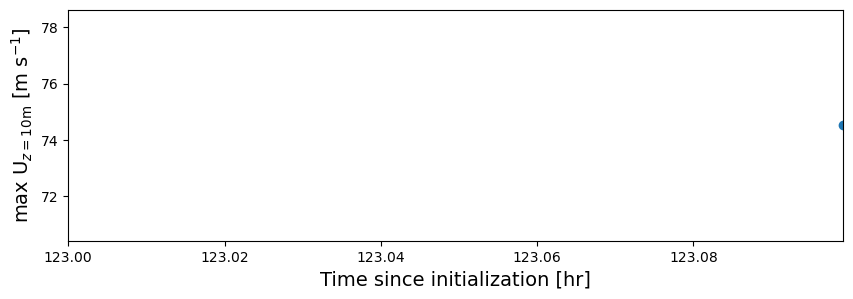

[123.09916667]
[74.52000427]


In [9]:
#%% Maximum velocity at the surface
temp_uv = np.zeros(np.shape(uv[:,0,:,:])) + uv[:,0,:,:]
temp_uv[:,0:10,:] = np.nan
temp_uv[:,-10:,:] = np.nan
temp_uv[:,:,0:10] = np.nan
temp_uv[:,:,-10:] = np.nan

max_uv_s = np.nanmax(temp_uv[:,:,:],axis=(1,2))

plt.figure(figsize=(10,3))
plt.plot(t_since[:],max_uv_s[:],'-o',zorder=0)
plt.xlabel('Time since initialization [hr]',fontsize=14)
plt.ylabel(r'max U$_{z=10 \rm m}$ [m s$^{-1}$]',fontsize=14)
plt.xlim(int(t_since[0]),t_since[-1])
# plt.xlim(80,t_since[-1])
# plt.ylim(58,70)
# plt.xlim(120,140)
# plt.legend()
plt.show()
plt.close()


# print(np.nanmean(temp_uv[-4]))
# print(ttime[-12])

print(t_since)
print(max_uv_s)



In [10]:
ttime[np.argmin(np.abs(t_since - 123))]

numpy.datetime64('2000-01-06T03:06:10')

In [11]:
np.argmin(np.abs(t_since-123))


0

In [12]:
# max_uv_s[16]

ix_max = 688; iy_max = 489


(0.0, 444.6273193359375)

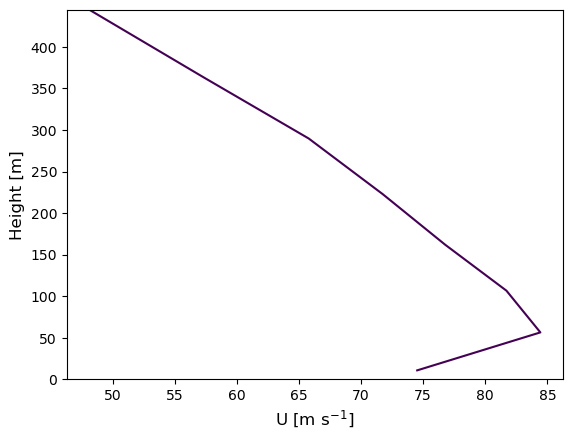

In [13]:
#%% Vertical profile of maximum wind speed
x_grid,y_grid = np.meshgrid(n_x,n_y)

z_max = height_agl[-1]
col = plt.cm.viridis(np.linspace(0,1,np.shape(theta)[0]))

plt.figure()
for it in np.arange(np.shape(theta)[0]):
    temp_uv = np.zeros(np.shape(uv[it,0,:,:])) + uv[it,0,:,:]
    temp_uv[0:10,:] = 0
    temp_uv[-10:,:] = 0
    temp_uv[:,0:10] = 0
    temp_uv[:,-10:] = 0
    uv_flat = np.reshape(temp_uv,[len(n_x)*len(n_y)])
    nx_flat = np.reshape(x_grid[:,:],[len(n_x)*len(n_y)])
    ny_flat = np.reshape(y_grid[:,:],[len(n_x)*len(n_y)])
    max_ws_ref = np.argmax(uv_flat)
    ix_max = np.argmin(np.abs(nx_flat[max_ws_ref] - n_x))
    iy_max = np.argmin(np.abs(ny_flat[max_ws_ref] - n_y))
    print('ix_max = '+str(ix_max) + '; iy_max = '+str(iy_max))
    plt.plot(uv[it,:,iy_max,ix_max],height_agl,color=col[it],label='t = '+str(ttime[it])[8:])
plt.xlabel(r'U [m s$^{-1}$]',fontsize=12)
plt.ylabel(r'Height [m]',fontsize=12)
plt.ylim(0,z_max)
# plt.legend()


In [14]:
#%% Find center of hurricane based on minimum wind speed
center = np.zeros([len(ttime),2]) + np.nan # [x,y]

X_grid,Y_grid = np.meshgrid(n_x,n_y)
X_grid = X_grid.flatten()
Y_grid = Y_grid.flatten()

for iitt in np.arange(np.shape(uv)[0]):
    
    temp_uv = np.zeros(np.shape(uv[iitt,0,:,:])) + uv[iitt,0,:,:]
    temp_uv[0:10,:] = np.nan
    temp_uv[-10:,:] = np.nan
    temp_uv[:,0:10] = np.nan
    temp_uv[:,-10:] = np.nan
    uv_flat = temp_uv.flatten() #uv[-1,0,:,:].flatten()
    uv_flat[np.isnan(uv_flat)] = 0
    max_ws_ref = np.argmax(uv_flat)

    lim_low_x = np.mean(n_x) - 0.1*n_x[-1]
    lim_low_y = np.mean(n_x) - 0.1*n_x[-1]
    lim_high_x = np.mean(n_x) + 0.1*n_x[-1]
    lim_high_y = np.mean(n_x) + 0.1*n_x[-1]

    if 'd01' in domain:
        if iitt>0:
#             lim_low_x = center[iitt-1,0] - 0.1*n_x[-1]
#             lim_low_y = center[iitt-1,1] - 0.1*n_x[-1]
#             lim_high_x = center[iitt-1,0] + 0.1*n_x[-1]
#             lim_high_y = center[iitt-1,1] + 0.1*n_x[-1]
            lim_low_x = X_grid[max_ws_ref] - 0.1*n_x[-1]
            lim_low_y = Y_grid[max_ws_ref] - 0.1*n_x[-1]
            lim_high_x = X_grid[max_ws_ref] + 0.1*n_x[-1] 
            lim_high_y = Y_grid[max_ws_ref] + 0.1*n_x[-1]
        
    # Create small meshgrid
    small_x,small_y = np.meshgrid(n_x[(n_x<lim_high_x)&(n_x>lim_low_x)],n_y[(n_y<lim_high_y)&(n_y>lim_low_y)])
    flat_smallX = small_x.flatten()
    flat_smallY = small_y.flatten()

    # Crop array
    temp_uv_1 = uv[iitt,0,(n_y<lim_high_y)&(n_y>lim_low_y),:]
    temp_uv_2 = temp_uv_1[:,(n_x<lim_high_x)&(n_x>lim_low_x)]
    # Flatten array
    temp_uv_flat = temp_uv_2.flatten()
    # Find location of minimum
    if np.any(temp_uv_flat)==True:
        i_min = np.argmin(temp_uv_flat)
        # Save location of minimum
        center[iitt,0] = flat_smallX[i_min]
        center[iitt,1] = flat_smallY[i_min]
    else:
        # Save location of minimum
        center[iitt,0] = np.mean(n_x)
        center[iitt,1] = np.mean(n_y)
print(center/dx)

[[727. 784.]]


In [15]:
#%% Get geometrical center using velocity contours
slow_winds = [5,7,9]
slow_winds = [5,10,15]
geo_center2 = np.zeros([len(ttime),len(slow_winds),2])

dyn_center = center
for iitt in np.arange(len(ttime)):
    ## Limits on what to plot
    lim_low_x = dyn_center[iitt,0] - 0.3*np.mean(n_x)
    lim_low_y = dyn_center[iitt,1] - 0.3*np.mean(n_y)
    lim_high_x = dyn_center[iitt,0] + 0.3*np.mean(n_x)
    lim_high_y = dyn_center[iitt,1] + 0.3*np.mean(n_y)
    
    
    # Get contours for a set of slow wind speeds close to the hurricane center
    small_x = n_x[(n_x>lim_low_x) & (n_x<lim_high_x)]
    small_y = n_y[(n_y>lim_low_y) & (n_y<lim_high_y)]
    small_uv = uv[iitt,iz,(n_y>lim_low_y) & (n_y<lim_high_y),:]
    small_uv = small_uv[:,(n_x>lim_low_x) & (n_x<lim_high_x)]
    cs = plt.contour(small_x/1000,small_y/1000,small_uv, slow_winds)
    paths = cs.collections
    plt.close()
    
#    plt.figure()
#    plt.contourf(small_x/1000,small_y/1000,small_uv)
#    plt.contour(small_x/1000,small_y/1000,small_uv, slow_winds,cmap=plt.cm.binary)
#    plt.show()
    
    # Get vertices of contours for each wind speed
    for i_ws in np.arange(len(slow_winds)):
        allP = paths[i_ws].get_paths()
        # Find longest path
        longest = 0
        len_longest = 0
        if len(allP)>0:
            for i_p in np.arange(len(allP)):
                if len(allP[i_p]) > len_longest:
                    longest = i_p
                    len_longest = len(allP[i_p])
            path = allP[longest]
            verts = path.vertices
            x_contour = verts[:,0]
            y_contour = verts[:,1]
            geo_center2[iitt,i_ws,0] = np.mean(x_contour)*1000
            geo_center2[iitt,i_ws,1] = np.mean(y_contour)*1000
        

/tmp/ipykernel_315421/471758227.py:21: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = cs.collections


In [16]:
#%% Choose which method for finding the center
meth_cent = 'oth'
if meth_cent=='geo':
    temp_cent = np.zeros_like(geo_center2[:,1,:]) + geo_center2[:,2,:] + 0.0
else:
    temp_cent = np.zeros_like(center) + center + 0.0


/tmp/ipykernel_315421/386499857.py:28: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(t_since[0],t_since[-1])


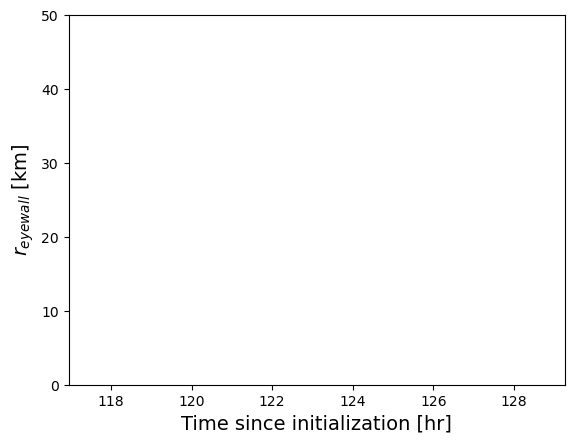

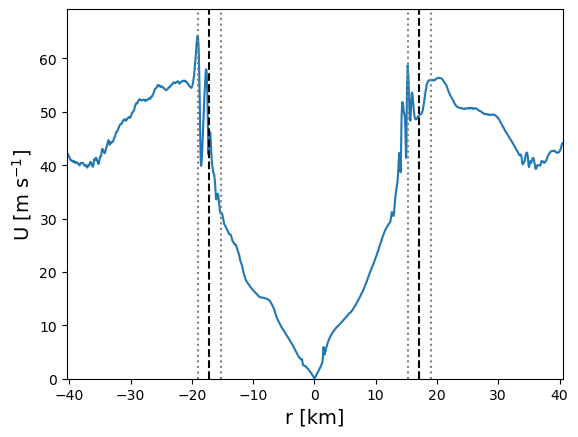

[17138.9023571]


In [17]:
#%% Find radius of eyewall in hurricane
r_eye = np.zeros(np.shape(ttime))
r1 = np.zeros(np.shape(ttime))
r2 = np.zeros(np.shape(ttime))

r_x = (n_x - temp_cent[-1,0])/1000


# Find radius of eyewall for each time
for ii in np.arange(0,len(ttime)):
    temp_uv = np.zeros(np.shape(uv[ii,0,:,:])) + uv[ii,0,:,:]
    temp_uv[0:10,:] = 0
    temp_uv[-10:,:] = 0
    temp_uv[:,0:10] = 0
    temp_uv[:,-10:] = 0
    
    i_r_max1 = np.argmax(temp_uv[int(temp_cent[ii,1]/dx),int(temp_cent[ii,0]/dx):])
    i_r_max2 = np.argmax(temp_uv[int(temp_cent[ii,1]/dx),0:int(temp_cent[ii,0]/dx)])
    r1[ii] = np.abs(n_x[int(temp_cent[ii,0]/dx):][i_r_max1] - temp_cent[ii,0])
    r2[ii] = np.abs(n_x[0:int(temp_cent[ii,0]/dx)][i_r_max2] - temp_cent[ii,0])
    r_eye[ii] = 0.5*(r1[ii] + r2[ii])

# Temporal evolution of hurricane eyewall
plt.figure()
plt.plot(t_since,r_eye/1000)
plt.xlabel('Time since initialization [hr]',fontsize=14)
plt.ylabel(r'$r_{eyewall}$ [km]',fontsize=14)
plt.xlim(t_since[0],t_since[-1])
plt.ylim(0,50)
plt.show()
plt.close() 

# Plot of wind speed
it = -1
plt.figure()
plt.plot((n_x-center[it,0])/1000,uv[it,0,int(temp_cent[it,1]/dx),:])
plt.plot(np.array([r_eye[it],r_eye[it]])/1000,[0,100],'--k')
plt.plot(np.array([-1*r_eye[it],-1*r_eye[it]])/1000,[0,100],'--k')

plt.plot(np.array([-1*r1[it],-1*r1[it]])/1000,[0,np.max(uv[:,0,int(temp_cent[it,1]/dx),:])+5],':',color='grey')
plt.plot(np.array([-1*r2[it],-1*r2[it]])/1000,[0,np.max(uv[:,0,int(temp_cent[it,1]/dx),:])+5],':',color='grey')

plt.plot(np.array([r1[it],r1[it]])/1000,[0,np.max(uv[:,0,int(temp_cent[it,1]/dx),:])+5],':',color='grey')
plt.plot(np.array([r2[it],r2[it]])/1000,[0,np.max(uv[:,0,int(temp_cent[it,1]/dx),:])+5],':',color='grey')

plt.xlim(np.min((n_x - center[it,0])/1000),np.max((n_x - center[it,0])/1000))
plt.xlim(np.max([-200,r_x[0]]),np.min([200,r_x[-1]]))
plt.ylim(0,np.max(uv[:,0,int(temp_cent[it,1]/dx),:])+5)
plt.xlabel('r [km]',fontsize=14)
plt.ylabel('U [m s$^{-1}$]',fontsize=14)
plt.show()
plt.close()  

print(r_eye)


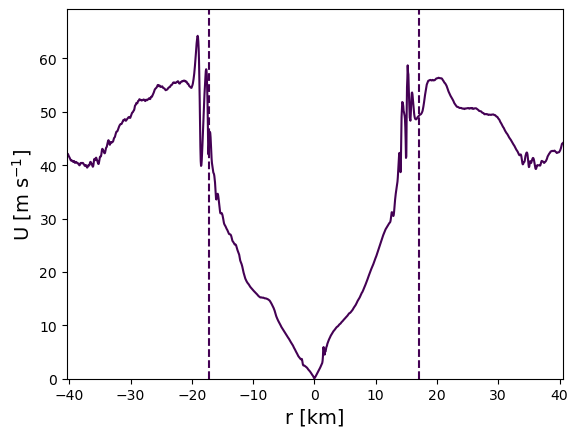

In [18]:
#%% Evolution of radius of maximum winds
cols = plt.cm.viridis(np.linspace(0,1,len(ttime)))
plt.figure()
for it in np.arange(len(ttime)):
    plt.plot((n_x-center[it,0])/1000,uv[it,0,int(temp_cent[it,1]/dx),:],color=cols[it])
    plt.plot(np.array([r_eye[it],r_eye[it]])/1000,[0,100],'--',color=cols[it])
    plt.plot(np.array([-1*r_eye[it],-1*r_eye[it]])/1000,[0,100],'--',color=cols[it])

plt.xlim(np.min((n_x - temp_cent[it,0])/1000),np.max((n_x - temp_cent[it,0])/1000))
plt.xlim(np.max([-350,r_x[0]]),np.min([350,r_x[-1]]))
plt.ylim(0,np.max(uv[:,0,int(temp_cent[it,1]/dx),:])+5)
plt.xlabel('r [km]',fontsize=14)
plt.ylabel('U [m s$^{-1}$]',fontsize=14)
plt.show()
plt.close() 


In [19]:
#%% Crop all 3D fields to a shared reference frame that is centered on the center of the hurricane
# Maximum distance from center of the hurricane
max_dist_fromCent = 200000

# Find the maximum radial distance from the hurricane's center that is shared for all times
for it in np.arange(len(ttime)):
    # Distance from hurricane cetner to domain boundaries
    dd_x = np.min([center[it,0] - n_x[0],n_x[-1] - center[it,0]])
    dd_y = np.min([center[it,1] - n_y[0],n_y[-1] - center[it,1]])
    # Minimum distance to domain boundaries
    dd = np.min([dd_x,dd_y])
    if dd<max_dist_fromCent:
        max_dist_fromCent = dd
# Round down
temp = np.floor(max_dist_fromCent/1000)
max_dist_fromCent = temp*1000

# Initialize array
u_r = np.zeros([len(ttime),len(height_agl),int(2*max_dist_fromCent/dx),int(2*max_dist_fromCent/dx)]) + np.nan
v_r = np.zeros([len(ttime),len(height_agl),int(2*max_dist_fromCent/dx),int(2*max_dist_fromCent/dx)]) + np.nan
w_r = np.zeros([len(ttime),len(height_agl),int(2*max_dist_fromCent/dx),int(2*max_dist_fromCent/dx)]) + np.nan
theta_r = np.zeros([len(ttime),len(height_agl),int(2*max_dist_fromCent/dx),int(2*max_dist_fromCent/dx)]) + np.nan
uv_r = np.zeros([len(ttime),len(height_agl),int(2*max_dist_fromCent/dx),int(2*max_dist_fromCent/dx)]) + np.nan

for iitt in np.arange(len(ttime)):
    # Geometrical center
    geo_cent = [center[iitt,0],center[iitt,1]]
    ix_c = int(geo_cent[0]/dx)
    iy_c = int(geo_cent[1]/dx)
    # Save portion of hurricane
    if iitt==0:
        dim1 = np.shape(u_r[iitt,:,:,:])[-1]
        dim2 = np.shape(u[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx),ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)])[-1]
    if dim1==dim2:
        u_r[iitt,:,:,:] = u[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx),ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)]
        v_r[iitt,:,:,:] = v[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx),ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)]
        w_r[iitt,:,:,:] = w[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx),ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)]
        theta_r[iitt,:,:,:] = theta[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx),ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)]
        uv_r[iitt,:,:,:] = uv[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx),ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)]
    else:
        u_r[iitt,:,:,:] = u[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx)+1,ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)+1]
        v_r[iitt,:,:,:] = v[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx)+1,ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)+1]
        w_r[iitt,:,:,:] = w[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx)+1,ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)+1]
        theta_r[iitt,:,:,:] = theta[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx)+1,ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)+1]
        uv_r[iitt,:,:,:] = uv[iitt,:,iy_c-int(max_dist_fromCent/dx):iy_c+int(max_dist_fromCent/dx)+1,ix_c-int(max_dist_fromCent/dx):ix_c+int(max_dist_fromCent/dx)+1]
    
    
# Release memory
# u = 0.0
# v = 0.0
# w = 0.0
# uv = 0.0
# theta = 0.0

# # Temporal average of centered velocity fields
# mean_u_r = np.nanmean(u_r,axis=0)
# mean_v_r = np.nanmean(v_r,axis=0)
# mean_w_r = np.nanmean(w_r,axis=0)
# mean_theta_r = np.nanmean(theta_r,axis=0)
mean_uv_r = np.nanmean(uv_r,axis=0)

# New distance arrays
n_x_r = np.arange(np.shape(mean_uv_r)[2])*dx
n_y_r = np.arange(np.shape(mean_uv_r)[1])*dx
temp_gridx,temp_gridy = np.meshgrid(n_x_r,n_y_r)
temp_uv = mean_uv_r[0,:,:].flatten()
temp_gridx = temp_gridx.flatten()
temp_gridy = temp_gridy.flatten()
n_x_r = n_x_r - temp_gridx[np.argmin(temp_uv)]
n_y_r = n_y_r - temp_gridy[np.argmin(temp_uv)]

temp_uv = 0.0
temp_gridx = 0.0
temp_gridy = 0.0

In [20]:
#%% Crop 3D fields to make them centered in a rectangle (x-y)
min_x = np.min(np.abs(np.array([n_x_r[0],n_x_r[-1]])))
min_y = np.min(np.abs(np.array([n_y_r[0],n_y_r[-1]])))

u_r = u_r[:,:,(n_y_r>-1*min_y)&(n_y_r<min_y),:]
u_r = u_r[:,:,:,(n_x_r>-1*min_x)&(n_x_r<min_x)]

v_r = v_r[:,:,(n_y_r>-1*min_y)&(n_y_r<min_y),:]
v_r = v_r[:,:,:,(n_x_r>-1*min_x)&(n_x_r<min_x)]

w_r = w_r[:,:,(n_y_r>-1*min_y)&(n_y_r<min_y),:]
w_r = w_r[:,:,:,(n_x_r>-1*min_x)&(n_x_r<min_x)]

theta_r = theta_r[:,:,(n_y_r>-1*min_y)&(n_y_r<min_y),:]
theta_r = theta_r[:,:,:,(n_x_r>-1*min_x)&(n_x_r<min_x)]

uv_r = uv_r[:,:,(n_y_r>-1*min_y)&(n_y_r<min_y),:]
uv_r = uv_r[:,:,:,(n_x_r>-1*min_x)&(n_x_r<min_x)]

n_x_r = n_x_r[(n_x_r>-1*min_x)&(n_x_r<min_x)]
n_y_r = n_y_r[(n_y_r>-1*min_y)&(n_y_r<min_y)]


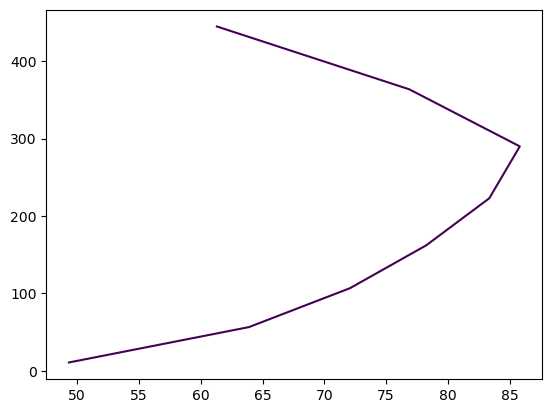

In [21]:
#%% Temporal evolution of velocity profiles at one location
r_hat = 1

plt.figure()
for i in np.arange(len(ttime)):
    ir = np.argmin(np.abs(n_x_r - r_eye[i]*r_hat))
    plt.plot(uv_r[i,:,int(0.5*len(n_y_r)),ir],height_agl,color=cols[i])

In [22]:
#%% Calculate temporal average after spinup
t0 = 3#7 #np.argmin(np.abs(t_since - 34))
t1 = t0+1 #np.argmin(np.abs(t_since - 40))
# t0 = np.argmin(np.abs(t_since - 39))
# t1 = np.argmin(np.abs(t_since - 51))

# Temporal average of centered velocity fields
mean_u_r = np.nanmean(u_r[t0:t1,:,:,:],axis=0)
mean_v_r = np.nanmean(v_r[t0:t1,:,:,:],axis=0)
mean_w_r = np.nanmean(w_r[t0:t1,:,:,:],axis=0)
mean_theta_r = np.nanmean(theta_r[t0:t1,:,:,:],axis=0)
mean_uv_r = np.nanmean(uv_r[t0:t1,:,:,:],axis=0)

print(ttime[t0:t1])
# print(ttime[t1])

/tmp/ipykernel_315421/816310079.py:8: RuntimeWarning: Mean of empty slice
  mean_u_r = np.nanmean(u_r[t0:t1,:,:,:],axis=0)
/tmp/ipykernel_315421/816310079.py:9: RuntimeWarning: Mean of empty slice
  mean_v_r = np.nanmean(v_r[t0:t1,:,:,:],axis=0)
/tmp/ipykernel_315421/816310079.py:10: RuntimeWarning: Mean of empty slice
  mean_w_r = np.nanmean(w_r[t0:t1,:,:,:],axis=0)
/tmp/ipykernel_315421/816310079.py:11: RuntimeWarning: Mean of empty slice
  mean_theta_r = np.nanmean(theta_r[t0:t1,:,:,:],axis=0)


[]


/tmp/ipykernel_315421/816310079.py:12: RuntimeWarning: Mean of empty slice
  mean_uv_r = np.nanmean(uv_r[t0:t1,:,:,:],axis=0)


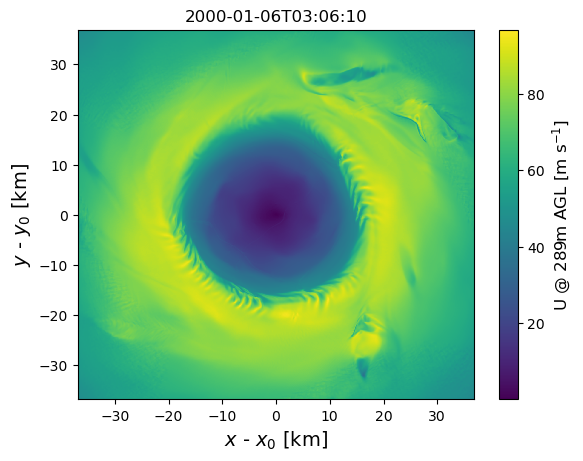

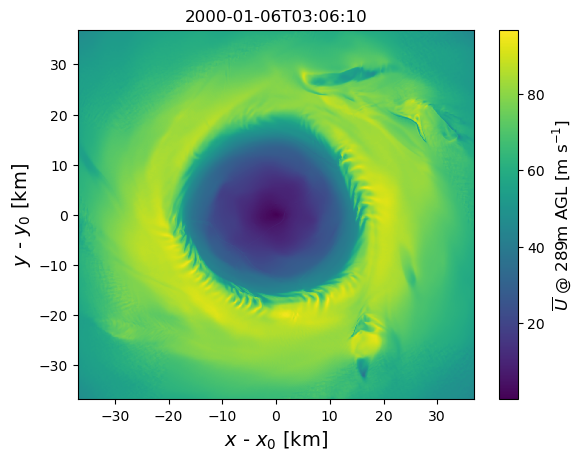

In [23]:
# Velocity contours at one height
iz = 5
it = -1 #len(ttime)-1

plt.figure()
plt.title(ttime[it])
im1 = plt.pcolormesh(n_x_r/1000,n_y_r/1000,uv_r[it,iz,:,:])
plt.xlabel(r'$x$ - $x_0$ [km]',fontsize=14)
plt.ylabel(r'$y$ - $y_0$ [km]',fontsize=14)
cbar = plt.colorbar(im1)
cbar.set_label(r'U @ ' + str(int(height_agl[iz])) + 'm AGL [m s$^{-1}$]',fontsize=12)
plt.show()
plt.close()  


plt.figure()
plt.title(ttime[it])
im1 = plt.pcolormesh(n_x_r/1000,n_y_r/1000,np.nanmean(uv_r[:,iz,:,:],axis=0))
plt.xlabel(r'$x$ - $x_0$ [km]',fontsize=14)
plt.ylabel(r'$y$ - $y_0$ [km]',fontsize=14)
cbar = plt.colorbar(im1)
cbar.set_label(r'$\overline{U}$ @ ' + str(int(height_agl[iz])) + 'm AGL [m s$^{-1}$]',fontsize=12)
plt.show()
plt.close()  


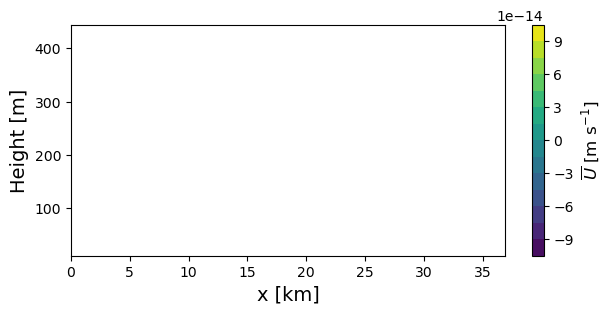

AssertionError: 

<Figure size 700x300 with 0 Axes>

In [24]:
#%% Slice of velocity fields
# Horizontal velocity field
plt.figure(figsize=(7,3))
im1 = plt.contourf((n_x_r-0.5*dx)/1000,height_agl,mean_uv_r[:,int(0.5*len(n_y_r)),:],levels=15) 
plt.xlabel('x [km]',fontsize=14)
plt.ylabel('Height [m]',fontsize=14)
plt.xlim(0,n_x_r[-1]/1000)
cbar = plt.colorbar(im1)
cbar.set_label(r'$\overline{U}$ [m s$^{-1}$]',fontsize=12)
plt.show()
plt.close()  

# Radial velocity field
plt.figure(figsize=(7,3))
minn = np.min(mean_u_r[:,int(0.5*len(n_y_r)),:])
maxx = np.max(mean_u_r[:,int(0.5*len(n_y_r)),:])
newCmap = cmocean.tools.crop(plt.cm.RdBu, minn, maxx, 0)
im1 = plt.pcolormesh((n_x_r-0.5*dx)/1000,height_agl,mean_u_r[:,int(0.5*len(n_y_r)),:],vmax=0,cmap=plt.cm.cividis) 
plt.xlabel('x [km]',fontsize=14)
plt.ylabel('Height [m]',fontsize=14)
plt.xlim(0,n_x_r[-1]/1000)
cbar = plt.colorbar(im1)
cbar.set_label(r'$\overline{u}_r$ [m s$^{-1}$]',fontsize=12)
plt.show()
plt.close() 

# Tangential velocity field
plt.figure(figsize=(7,3))
# newCmap = cmocean.tools.crop(plt.cm.RdBu, np.min(mean_v_r[:,int(0.5*len(n_y_r)),:]), np.max(mean_v_r[:,int(0.5*len(n_y_r)),:]), 0)
im1 = plt.pcolormesh((n_x_r-0.5*dx)/1000,height_agl,mean_v_r[:,int(0.5*len(n_y_r)),:],cmap=plt.cm.viridis,vmin=0) 
plt.xlabel('x [km]',fontsize=14)
plt.ylabel('Height [m]',fontsize=14)
plt.xlim(0,n_x_r[-1]/1000)
cbar = plt.colorbar(im1)
cbar.set_label(r'$\overline{u}_t$ [m s$^{-1}$]',fontsize=12)
plt.show()
plt.close() 

# Vertical velocity field
plt.figure(figsize=(7,3))
minn = np.min(mean_w_r[:,int(0.5*len(n_y_r)),:])
maxx = np.max(mean_w_r[:,int(0.5*len(n_y_r)),:])
newCmap = cmocean.tools.crop(plt.cm.RdBu_r, minn, maxx, 0)
im1 = plt.pcolormesh((n_x_r-0.5*dx)/1000,height_agl,mean_w_r[:,int(0.5*len(n_y_r)),:],cmap=newCmap,vmin=minn,vmax=maxx) 
plt.xlabel('x [km]',fontsize=14)
plt.ylabel('Height [m]',fontsize=14)
plt.xlim(0,n_x_r[-1]/1000)
cbar = plt.colorbar(im1)
cbar.set_label(r'$\overline{w}$ [m s$^{-1}$]',fontsize=12)
plt.show()
plt.close()  

/tmp/ipykernel_315421/2759567549.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  r_hats = np.arange(0.4,2,np.max([0.2*r_max,int(dx)])/r_max)


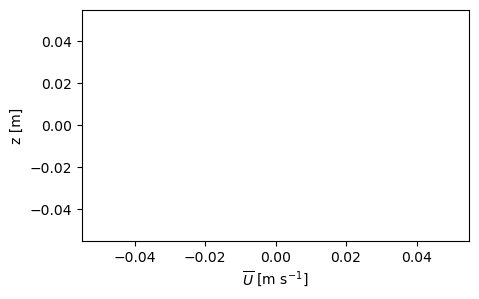

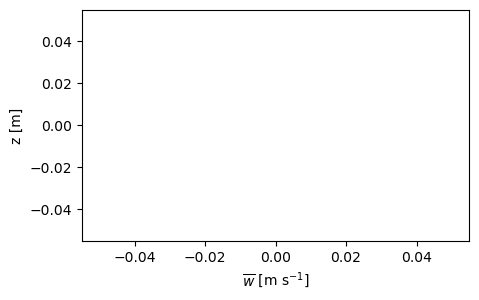

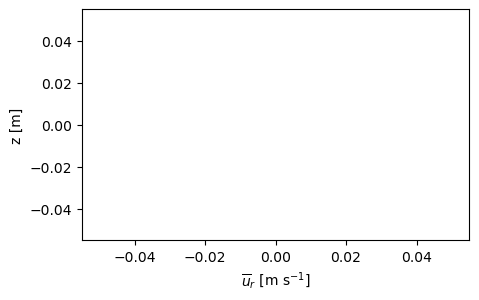

In [25]:
#%% Radial evolution of time-averaged velocity profiles for times of interest
r_max = np.abs(n_x_r[int(0.5*len(n_x_r)) + np.argmax(mean_uv_r[0,int(0.5*len(n_y_r)),int(0.5*len(n_x_r)):])])
r_hats = np.arange(0.4,2,np.max([0.2*r_max,int(dx)])/r_max)

cols_r_less_than_R = plt.cm.Blues(np.linspace(0.4,1,len(r_hats[r_hats<1])))
cols_r_greater_than_R = plt.cm.Reds_r(np.linspace(0.1,0.8,len(r_hats[r_hats>1])))

closest_to_R = np.argmin(np.abs(r_hats - 1)) #+ 1

# Horizontal velocity
c_less = 0
c_greater = 0
plt.figure(figsize=(5,3))
for i in np.arange(len(r_hats)):
    ir = np.argmin(np.abs(n_x_r - r_max*r_hats[i]))
    if i==closest_to_R:
        plt.plot(mean_uv_r[:,int(0.5*len(n_y_r)),ir],height_agl,'-o',color='black')
    elif r_hats[i]<1:
        plt.plot(mean_uv_r[:,int(0.5*len(n_y_r)),ir],height_agl,color=cols_r_less_than_R[c_less])
        c_less = c_less + 1
    else:# r_hats[i]>1:
        plt.plot(mean_uv_r[:,int(0.5*len(n_y_r)),ir],height_agl,color=cols_r_greater_than_R[c_greater])
        c_greater = c_greater + 1
plt.xlabel(r"$\overline{U}$ [m s$^{-1}$]")
plt.ylabel("z [m]")
plt.show()
plt.close()

# Vertical velocity
c_less = 0
c_greater = 0
plt.figure(figsize=(5,3))
for i in np.arange(len(r_hats)):
    ir = np.argmin(np.abs(n_x_r - r_max*r_hats[i]))
    if i==closest_to_R:
        plt.plot(mean_w_r[:,int(0.5*len(n_y_r)),ir],height_agl,'-o',color='black')
    elif r_hats[i]<1:
        plt.plot(mean_w_r[:,int(0.5*len(n_y_r)),ir],height_agl,color=cols_r_less_than_R[c_less])
        c_less = c_less + 1
    else:# r_hats[i]>1:
        plt.plot(mean_w_r[:,int(0.5*len(n_y_r)),ir],height_agl,color=cols_r_greater_than_R[c_greater])
        c_greater = c_greater + 1
plt.xlabel(r"$\overline{w}$ [m s$^{-1}$]")
plt.ylabel("z [m]")
plt.show()
plt.close()

# Radial velocity
c_less = 0
c_greater = 0
plt.figure(figsize=(5,3))
for i in np.arange(len(r_hats)):
    ir = np.argmin(np.abs(n_x_r - r_max*r_hats[i]))
    if i==closest_to_R:
        plt.plot(mean_u_r[:,int(0.5*len(n_y_r)),ir],height_agl,'-o',color='black')
    elif r_hats[i]<1:
        plt.plot(mean_u_r[:,int(0.5*len(n_y_r)),ir],height_agl,color=cols_r_less_than_R[c_less])
        c_less = c_less + 1
    else:# r_hats[i]>1:
        plt.plot(mean_u_r[:,int(0.5*len(n_y_r)),ir],height_agl,color=cols_r_greater_than_R[c_greater])
        c_greater = c_greater + 1
plt.xlabel(r"$\overline{u}_r$ [m s$^{-1}$]")
plt.ylabel("z [m]")
plt.show()
plt.close()

In [26]:
center/dx

array([[727., 784.]])

In [ ]:
ttime[np.argmin(np.abs(t_since-40))]
center[np.argmin(np.abs(t_since-40)),:]/dx

In [ ]:
np.argmin(np.abs(t_since-40))

In [ ]:
#%% Relative location of nest within parent domain
plt.figure(figsize=(6,5))
it = 10 #np.argmin(np.abs(ttime - np.datetime64('2000-01-06T01:00:11')))
plt.title('t = '+str(ttime[it])[8:])
# im1 = plt.pcolormesh(n_x/1000,n_y/1000,uv[it,0,:,:])
im1 = plt.contourf(n_x/1000,n_y/1000,uv[it,0,:,:])
# dx_nest = dx/9
# nx = 657
# ix = int(temp_cent[it,0]/dx - 0.5*nx*dx_nest/dx)
# iy = int(temp_cent[it,1]/dx - 0.5*nx*dx_nest/dx)

dx_nest = dx/9/3
nx = 1458
ix = int(temp_cent[it,0]/dx - 0.5*nx*dx_nest/dx)
iy = int(temp_cent[it,1]/dx - 0.5*nx*dx_nest/dx)
#     ix = int(center[it,0]/dx - 0.5*nx*dx_nest/dx)
#     iy = int(center[it,1]/dx - 0.5*nx*dx_nest/dx)
plt.fill((np.array([ix*dx,ix*dx + nx*dx_nest,ix*dx + nx*dx_nest,ix*dx])-1)/1000,np.array([iy*dx,iy*dx,iy*dx + nx*dx_nest,iy*dx + nx*dx_nest])/1000,facecolor='none',edgecolor='r',linestyle=':',label='d02')
plt.scatter(temp_cent[:,0]/1000,temp_cent[:,1]/1000,color='red')#,markersize=3,'o-')

# plt.scatter(np.mean(center[:,0]/1000),np.mean(center[:,1]/1000),s=5,c='white',marker='+')
plt.scatter(center[it,0]/1000,center[it,1]/1000,s=5,c='red',marker='o')
plt.scatter(geo_center2[it,0,0]/1000,geo_center2[it,0,1]/1000,s=15,c='orange',marker='+')
plt.scatter(temp_cent[it,0]/1000,temp_cent[it,1]/1000,color='white')#,markersize=3,'o-')

# aa = np.mean(geo_center2[:,:,:]/1000,axis=1)
# plt.scatter(aa[0][0],aa[0][1],color='black')#,markersize=3,'o-')

# for i_s in np.arange(np.shape(locs)[0]):
#     plt.scatter(n_x[locs[i_s,0]]/1000,n_y[locs[i_s,1]]/1000,color='white',marker='.',s=5)#,markersize=3,'o-')


# ix_avg = 129#+1 #int(np.median(temp_cent[-2:,0])/dx - 0.5*nx*dx_nest/dx)+2-1
# iy_avg = 133#+1 #int(np.median(temp_cent[-2:,1])/dx - 0.5*nx*dx_nest/dx)-2+1+4-1
# plt.fill((np.array([ix_avg*dx,ix_avg*dx + nx*dx_nest,ix_avg*dx + nx*dx_nest,ix_avg*dx])-1)/1000,np.array([iy_avg*dx,iy_avg*dx,iy_avg*dx + nx*dx_nest,iy_avg*dx + nx*dx_nest])/1000,facecolor='none',edgecolor='white',linestyle=':',label='d02')
# print('ix_avg = '+str(ix_avg)+'; iy_avg = '+str(iy_avg))

ix_avg = 199 #int(np.median(temp_cent[it:it+2,0])/dx - 0.5*nx*dx_nest/dx)
iy_avg = 196 #int(np.median(temp_cent[it:it+2,1])/dx - 0.5*nx*dx_nest/dx)#-2
ix_avg = 200 #int(np.median(temp_cent[it:it+2,0])/dx - 0.5*nx*dx_nest/dx)
iy_avg = 199 #int(np.median(temp_cent[it:it+2,1])/dx - 0.5*nx*dx_nest/dx)#-2
plt.fill((np.array([ix_avg*dx,ix_avg*dx + nx*dx_nest,ix_avg*dx + nx*dx_nest,ix_avg*dx])-1)/1000,np.array([iy_avg*dx,iy_avg*dx,iy_avg*dx + nx*dx_nest,iy_avg*dx + nx*dx_nest])/1000,facecolor='none',edgecolor='orange',linestyle=':',label='d02')

# ix_avg = int(0.5*(113 + 137))
# iy_avg = int(0.5*(118 + 166))
# plt.fill((np.array([ix_avg*dx,ix_avg*dx + nx*dx_nest,ix_avg*dx + nx*dx_nest,ix_avg*dx])-1)/1000,np.array([iy_avg*dx,iy_avg*dx,iy_avg*dx + nx*dx_nest,iy_avg*dx + nx*dx_nest])/1000,facecolor='none',edgecolor='red',linestyle='-',label='d02')


#plt.fill(n_x[np.array([305,341,341,305])]/1000,n_y[np.array([421,421,448,448])]/1000,facecolor='none',edgecolor='r',linestyle=':',label='d04')
plt.legend()
cbar = plt.colorbar(im1)
cbar.set_label('U @ ' + str(int(height_agl[0])) + 'm AGL [m s$^{-1}$]',fontsize=12)
plt.ylabel('y [km]',fontsize=14)
plt.xlabel('x [km]',fontsize=14)
# plt.ylim((iy-20)*dx/1000,(iy+20)*dx/1000 + nx*dx_nest/1000)
# plt.xlim((ix-20)*dx/1000,(ix+20)*dx/1000 + nx*dx_nest/1000)

# plt.xlim(700,1300)
# plt.ylim(700,1300)

# plt.xlim(180,280)
# plt.ylim(190,290)

plt.xlim((temp_cent[it,0]-0.6*nx*dx_nest)/1000,(temp_cent[it,0]+0.6*nx*dx_nest)/1000)
plt.ylim((temp_cent[it,1]-0.6*nx*dx_nest)/1000,(temp_cent[it,1]+0.6*nx*dx_nest)/1000)


plt.tight_layout()
plt.show()
plt.close()

print('ix = '+str(ix)+'; iy = '+str(iy))
print('')
print(ttime[it])
print(np.mean(geo_center2[it,:,:],axis=0))
print('')
print('ix_avg = '+str(ix_avg)+'; iy_avg = '+str(iy_avg))


In [ ]:
ttime[-2]

In [ ]:
r_eye[it]

In [ ]:
t_since[it]